In [1]:
import os
print(f"当前工作目录：{os.getcwd()}")
# 设置工作目录
# os.chdir('/root/lanyun-tmp/kan-things')

%reload_ext autoreload
%autoreload 2

当前工作目录：/root/lanyun-tmp/kan-things/Efficient-KAN-in-Chinese


In [6]:
from test_groupkan import train, KAN, MLP
from ikan.GroupKAN import GroupKAN, GroupKANLinear
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
import numpy as np
import pandas as pd
from test_groupkan import complex_equation

np.random.seed(42)

# 生成随机输入数据 (10000个样本)
n_samples = 10000
X = np.random.randn(n_samples, 8) * 2  # 8个特征/变量，扩大取值范围



# 计算每个样本的目标值
y = np.array([complex_equation(x) for x in X])

# 转换为DataFrame便于查看
data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(8)])
data['y'] = y

# 显示前5行数据
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,0.993428,-0.276529,1.295377,3.046060,-0.468307,-0.468274,3.158426,1.534869,11.931326
1,-0.938949,1.085120,-0.926835,-0.931460,0.483925,-3.826560,-3.449836,-1.124575,-1.785756
2,-2.025662,0.628495,-1.816048,-2.824607,2.931298,-0.451553,0.135056,-2.849496,-7.329987
3,-1.088765,0.221845,-2.301987,0.751396,-1.201277,-0.583387,-1.203413,3.704556,-0.439691
4,-0.026994,-2.115422,1.645090,-2.441687,0.417727,-3.919340,-2.656372,0.393722,17.903385


In [7]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
criterion = nn.MSELoss()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = MLP().to(device)
kan = KAN().to(device)

for model in [mlp, kan]:

    # 统计模型参数总数
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f'模型名称: {model.__class__.__name__}')
    print(f'模型总参数数量: {total_params:,}')
    print(f'可训练参数数量: {trainable_params:,}\n')


模型名称: MLP
模型总参数数量: 2,730
可训练参数数量: 2,730

模型名称: KAN
模型总参数数量: 2,755
可训练参数数量: 2,755



In [6]:
for model in [mlp, kan]:
    print(f'\n训练模型: {model.__class__.__name__}')
    optimizer = optim.Adam(model.parameters(), 1e-3)
    train(model, train_loader, test_loader, criterion, optimizer, 200)


训练模型: MLP


Epoch [1/200], Train Loss: 174.6417, Test Loss: 120.6514, Test R2: 0.4077
Epoch [10/200], Train Loss: 36.8595, Test Loss: 31.7692, Test R2: 0.8437
Epoch [20/200], Train Loss: 11.3537, Test Loss: 10.6486, Test R2: 0.9477
Epoch [30/200], Train Loss: 5.5068, Test Loss: 6.1955, Test R2: 0.9696
Epoch [40/200], Train Loss: 3.3294, Test Loss: 4.4616, Test R2: 0.9782
Epoch [50/200], Train Loss: 2.3483, Test Loss: 3.8362, Test R2: 0.9812
Epoch [60/200], Train Loss: 1.7967, Test Loss: 3.3877, Test R2: 0.9834
Epoch [70/200], Train Loss: 1.5793, Test Loss: 2.9513, Test R2: 0.9855
Epoch [80/200], Train Loss: 1.4965, Test Loss: 2.6821, Test R2: 0.9869
Epoch [90/200], Train Loss: 1.2635, Test Loss: 2.5482, Test R2: 0.9875
Epoch [100/200], Train Loss: 1.2807, Test Loss: 2.6817, Test R2: 0.9868
Epoch [110/200], Train Loss: 1.1336, Test Loss: 2.2601, Test R2: 0.9890
Epoch [120/200], Train Loss: 1.1089, Test Loss: 2.2356, Test R2: 0.9891
Epoch [130/200], Train Loss: 1.0595, Test Loss: 2.2229, Test R2: 0.

In [9]:
import torch
from torch import nn

# 加载两个模型
kan_model = KAN().to(device)
kan_model.load_state_dict(torch.load('best_KAN_model.pth')['model_state_dict'])
kan_model.eval()

mlp_model = MLP().to(device) 
mlp_model.load_state_dict(torch.load('best_MLP_model.pth')['model_state_dict'])
mlp_model.eval()


MLP(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=65, bias=True)
    (1): ReLU()
    (2): Linear(in_features=65, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [17]:
# 生成5个测试数据
test_X = np.random.randn(5, 8) * 2
test_X_df = pd.DataFrame(test_X, columns=[f'x{i+1}' for i in range(8)])

# 计算测试集目标值
test_y = np.array([complex_equation(x) for x in test_X])

# 转换为tensor
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).reshape(-1, 1).to(device)


# 预测
with torch.no_grad():
    kan_pred = kan_model(test_X_tensor)
    mlp_pred = mlp_model(test_X_tensor)

# 计算差值并展示结果
results = pd.DataFrame({
    '真实值': test_y,
    'KAN预测': kan_pred.cpu().numpy().flatten(),
    'MLP预测': mlp_pred.cpu().numpy().flatten(),
    'KAN差值': np.abs(test_y - kan_pred.cpu().numpy().flatten()),
    'MLP差值': np.abs(test_y - mlp_pred.cpu().numpy().flatten())
})

print("预测结果对比:")
results


预测结果对比:


,真实值,KAN预测,MLP预测,KAN差值,MLP差值
0,-2.001413,-1.404157,-0.968800,0.597256,1.032613
1,6.378740,7.008902,5.704961,0.630162,0.673778
2,11.481759,11.557876,11.064093,0.076117,0.417666
3,-5.418270,-5.309832,-5.977479,0.108438,0.559209
4,-5.865976,-5.800598,-5.695709,0.065378,0.170267


在1000个测试样本中:
KAN表现更好的样本数: 619 (61.90%)
MLP表现更好的样本数: 381 (38.10%)
两者表现相同的样本数: 0 (0.00%)

平均绝对误差比较:
KAN平均绝对误差: 0.636430
MLP平均绝对误差: 0.938345
误差比例 (KAN/MLP): 0.6782


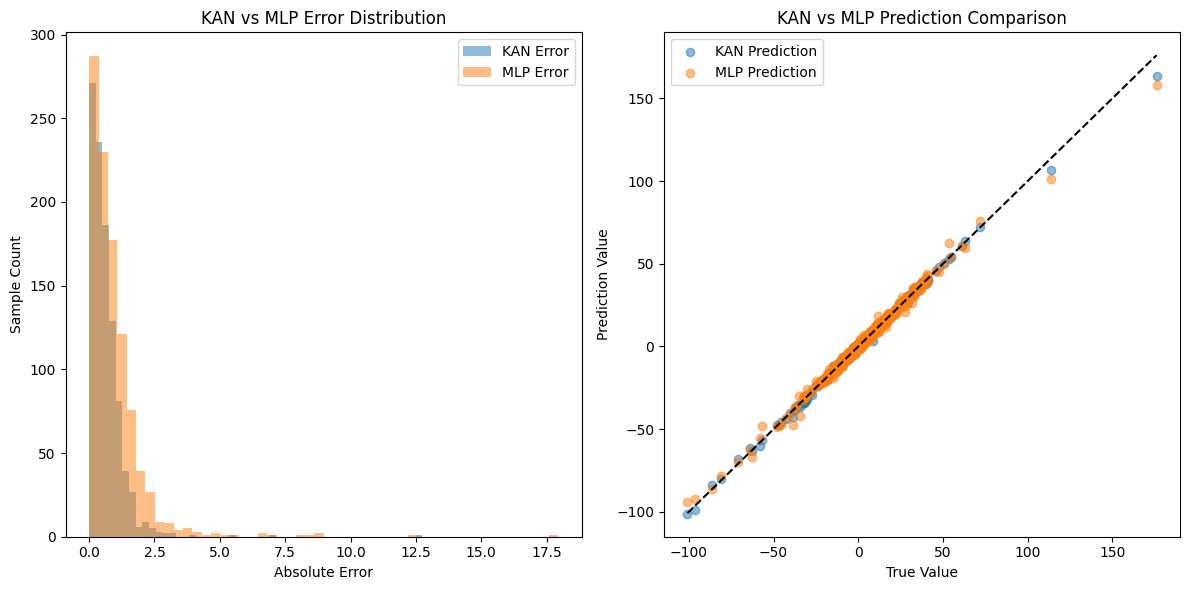

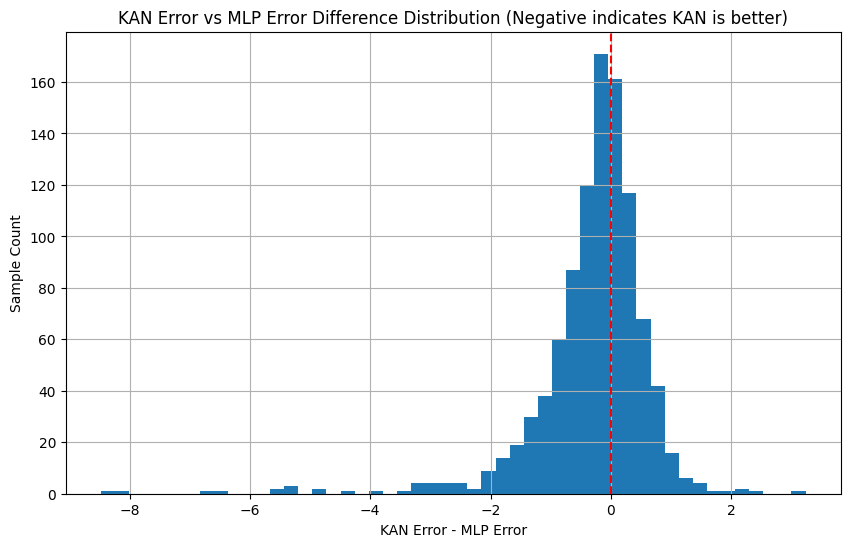

In [18]:
import matplotlib.pyplot as plt

# 生成1000个测试数据
n_test = 1000
test_X = np.random.randn(n_test, 8) * 2

# 计算测试集目标值
test_y = np.array([complex_equation(x) for x in test_X])


# 转换为tensor
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).reshape(-1, 1).to(device)

# 预测
with torch.no_grad():
    kan_pred = kan_model(test_X_tensor).cpu().numpy().flatten()
    mlp_pred = mlp_model(test_X_tensor).cpu().numpy().flatten()

# 计算每个样本的绝对误差
kan_errors = np.abs(test_y - kan_pred)
mlp_errors = np.abs(test_y - mlp_pred)

# 计算每个样本哪个模型更好
kan_better = kan_errors < mlp_errors
mlp_better = mlp_errors < kan_errors
equal_performance = np.isclose(kan_errors, mlp_errors)

# 统计各模型优势样本数
kan_better_count = np.sum(kan_better)
mlp_better_count = np.sum(mlp_better)
equal_count = np.sum(equal_performance)

# 计算平均绝对误差
kan_mae = np.mean(kan_errors)
mlp_mae = np.mean(mlp_errors)

# 打印结果
print(f"在{n_test}个测试样本中:")
print(f"KAN表现更好的样本数: {kan_better_count} ({kan_better_count/n_test*100:.2f}%)")
print(f"MLP表现更好的样本数: {mlp_better_count} ({mlp_better_count/n_test*100:.2f}%)")
print(f"两者表现相同的样本数: {equal_count} ({equal_count/n_test*100:.2f}%)")
print("\n平均绝对误差比较:")
print(f"KAN平均绝对误差: {kan_mae:.6f}")
print(f"MLP平均绝对误差: {mlp_mae:.6f}")
print(f"误差比例 (KAN/MLP): {kan_mae/mlp_mae:.4f}")

# 可视化误差分布
plt.figure(figsize=(12, 6))

# 误差比较直方图
plt.subplot(1, 2, 1)
plt.hist(kan_errors, alpha=0.5, bins=50, label='KAN Error')
plt.hist(mlp_errors, alpha=0.5, bins=50, label='MLP Error')
plt.legend()
plt.title('KAN vs MLP Error Distribution')
plt.xlabel('Absolute Error')
plt.ylabel('Sample Count')

# 散点图比较
plt.subplot(1, 2, 2)
plt.scatter(test_y, kan_pred, alpha=0.5, label='KAN Prediction')
plt.scatter(test_y, mlp_pred, alpha=0.5, label='MLP Prediction')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'k--')
plt.legend()
plt.title('KAN vs MLP Prediction Comparison')
plt.xlabel('True Value')
plt.ylabel('Prediction Value')

plt.tight_layout()
plt.show()

# 计算两种模型的相对误差表现
error_diff = kan_errors - mlp_errors
plt.figure(figsize=(10, 6))
plt.hist(error_diff, bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('KAN Error vs MLP Error Difference Distribution (Negative indicates KAN is better)')
plt.xlabel('KAN Error - MLP Error')
plt.ylabel('Sample Count')
plt.grid(True)
plt.show()